In [1]:
import cv2
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import swing3dify.time_adjustment as ta
from swing3dify.core import compute_camera_parameters, reconstruct_3D
from swing3dify.visualizations import draw_feature_matches, visualize_3d_points, draw_epipolar_lines, plot_3d_points
from calibration_data import KNOWN_CALIBRATION_DATA

In [2]:
GRAPH_SHOW = False

In [3]:
club1 = pd.read_csv('../data/club/data/red_0712_0016/position_data.csv')
club2 = pd.read_csv('../data/club/data/white_0712_0016/position_data.csv')

conf1 = pd.read_csv('../data/club/data/red_0712_0016/confidence_data.csv')
conf2 = pd.read_csv('../data/club/data/white_0712_0016/confidence_data.csv')

In [4]:
club1.interpolate(method='linear', both=True, inplace=True)
club2.interpolate(method='linear', both=True, inplace=True)

In [5]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(club1['frame'], club1['HOSEL_y'], label='red')
    ax.plot(club2['frame'], club2['HOSEL_y'], label='white')
    ax.legend()
    ax.set_title('HOSEL y position ratio')
    ax.set_xlabel('frame')
    ax.set_ylabel('position ratio')
    plt.show()

In [6]:
delay_frame = ta.calculate_delay_frame(club1, club2, 'HOSEL')
print(f'delay_frame: {delay_frame}')

delay_frame: -32


In [7]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(club1['frame'], club1['HOSEL_y'], label='red')
    ax.plot(club2['frame'] + delay_frame, club2['HOSEL_y'], label='white')
    ax.legend()
    ax.set_title('HOSEL y position ratio')
    ax.set_xlabel('frame')
    ax.set_ylabel('position ratio')
    plt.show()

In [8]:
img_num = 50

img1 = cv2.imread(f'../data/img/red_0712_0016/red_0712_0016_{img_num}.jpg')
img2 = cv2.imread(f'../data/img/white_0712_0016/white_0712_0016_{img_num - delay_frame}.jpg')

In [9]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [10]:
if GRAPH_SHOW:
    rgb_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    cmap = plt.get_cmap('viridis')

    height, width, _ = img1.shape

    min_frame = club1['frame'].min()
    max_frame = club1['frame'].max()
    for x, y, i in zip(club1['HOSEL_x'], club1['HOSEL_y'], club1['frame']):
        normalized_value = (i - min_frame) / (max_frame - min_frame)
        color = cmap(normalized_value)[:-1]
        color = tuple([int(c * 255) for c in color])
        cv2.circle(rgb_img1, (int(x*width), int(y*height)), 5, color, 5)

    min_frame = club2['frame'].min()
    max_frame = club2['frame'].max()
    for x, y, i in zip(club2['HOSEL_x'], club2['HOSEL_y'], club2['frame']):
        normalized_value = (i - min_frame) / (max_frame - min_frame)
        color = cmap(normalized_value)[:-1]
        color = tuple([int(c * 255) for c in color])
        cv2.circle(rgb_img2, (int(x*width), int(y*height)), 5, color, 5)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(rgb_img1)
    ax[1].imshow(rgb_img2)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [11]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(3, 1, figsize=(10, 6))

    ax[0].plot(club1['frame'], club1['HOSEL_y'], label='red')
    ax[0].plot(club2['frame'] + delay_frame, club2['HOSEL_y'], label='white')
    ax[0].legend()

    ax[1].plot(conf1['frame'], conf1['BOX_conf'], label='red')
    ax[1].plot(conf2['frame'] + delay_frame, conf2['BOX_conf'], label='white')
    ax[1].legend()

    ax[2].plot(conf1['frame'], conf1['HOSEL_conf'], label='red')
    ax[2].plot(conf2['frame'] + delay_frame, conf2['HOSEL_conf'], label='white')
    ax[2].legend()

    plt.show()

In [12]:
thr = 0.90

new_club1 = club1.copy()
new_club2 = club2.copy()

new_club1.loc[conf1['BOX_conf'] <= thr, 'HOSEL_x'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'HOSEL_y'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'GRIP_x'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'GRIP_y'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'TOE_x'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'TOE_y'] = None

new_club2.loc[conf2['BOX_conf'] <= thr, 'HOSEL_x'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'HOSEL_y'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'GRIP_x'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'GRIP_y'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'TOE_x'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'TOE_y'] = None

new_club1['new_frame'] = new_club1['frame']
new_club2['new_frame'] = new_club2['frame'] + delay_frame

In [13]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(3, 1, figsize=(14, 12))

    ax[0].scatter(new_club1['new_frame'], new_club1['HOSEL_y'], s=3, label='red')
    ax[0].scatter(new_club2['new_frame'], new_club2['HOSEL_y'], s=3, label='white')
    ax[0].legend()
    ax[0].set_title('HOSEL y position ratio')
    # ax[0].set_xlabel('frame')
    ax[0].set_ylabel('position ratio')


    ax[1].scatter(conf1['frame'], conf1['BOX_conf'], s=3, label='red')
    ax[1].scatter(conf2['frame'] + delay_frame, conf2['BOX_conf'], s=3, label='white')
    ax[1].legend()
    ax[1].set_title('BOX confidence score')
    # ax[1].set_xlabel('frame')
    ax[1].set_ylabel('confidence score')

    ax[2].scatter(conf1['frame'], conf1['HOSEL_conf'], s=3, label='red')
    ax[2].scatter(conf2['frame'] + delay_frame, conf2['HOSEL_conf'], s=3, label='white')
    ax[2].legend()
    ax[2].set_title('HOSEL confidence score')
    ax[2].set_xlabel('frame')
    ax[2].set_ylabel('confidence score')

    plt.show()

In [14]:
index1 = set(new_club1[~new_club1.isnull().any(axis=1)]['new_frame'].values)
index2 = set(new_club2[~new_club2.isnull().any(axis=1)]['new_frame'].values)

common_index = np.array(sorted(list(index1 & index2)))
print(f'common index size: {len(common_index)}')

common index size: 197


In [15]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.scatter(common_index, new_club1[new_club1['new_frame'].isin(common_index)]['HOSEL_y'], s=3, label='red')
    ax.scatter(common_index, new_club2[new_club2['new_frame'].isin(common_index)]['HOSEL_y'], s=3, label='white')
    ax.legend()
    ax.set_title('HOSEL y position ratio (synced & high confidence)')
    ax.set_xlabel('frame')
    ax.set_ylabel('position ratio')
    plt.show()

In [16]:
sync_club1 = new_club1[new_club1['new_frame'].isin(common_index)].copy()
sync_club2 = new_club2[new_club2['new_frame'].isin(common_index)].copy()

height, width, _ = img1.shape

for c in sync_club1.columns[1::2]:
    sync_club1[c] = sync_club1[c] * width
    sync_club2[c] = sync_club2[c] * width
for c in sync_club1.columns[2::2]:
    sync_club1[c] = sync_club1[c] * height
    sync_club2[c] = sync_club2[c] * height

In [17]:
sync_index1 = set(sync_club1['new_frame'].values)
sync_index2 = set(sync_club2['new_frame'].values)
print(f'sync index size: {len(sync_index1)}')
print(f'sync index size: {len(sync_index2)}')
print(f'sync index size: {len(sync_index1 & sync_index2)}')

sync index size: 197
sync index size: 197
sync index size: 197


In [18]:
sync_club1.to_csv('../data/sample/club1_position_data.csv', index=False, header=True)
sync_club2.to_csv('../data/sample/club2_position_data.csv', index=False, header=True)

In [19]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.scatter(sync_club1['new_frame'], sync_club1['HOSEL_y'], s=3, label='red')
    ax.scatter(sync_club2['new_frame'], sync_club2['HOSEL_y'], s=3, label='white')
    ax.legend()
    plt.show()

In [20]:
if GRAPH_SHOW:
    rgb_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    cmap = plt.get_cmap('viridis')

    height, width, _ = img1.shape

    min_frame = sync_club1['new_frame'].min()
    max_frame = sync_club1['new_frame'].max()
    for x, y, i in zip(sync_club1['HOSEL_x'], sync_club1['HOSEL_y'], sync_club1['frame']):
        normalized_value = (i - min_frame) / (max_frame - min_frame)
        color = cmap(normalized_value)[:-1]
        color = tuple([int(c * 255) for c in color])
        cv2.circle(rgb_img1, (int(x*width), int(y*height)), 5, color, 5)

    min_frame = sync_club2['new_frame'].min()
    max_frame = sync_club2['new_frame'].max()
    for x, y, i in zip(sync_club2['HOSEL_x'], sync_club2['HOSEL_y'], sync_club2['frame']):
        normalized_value = (i - min_frame) / (max_frame - min_frame)
        color = cmap(normalized_value)[:-1]
        color = tuple([int(c * 255) for c in color])
        cv2.circle(rgb_img2, (int(x*width), int(y*height)), 5, color, 5)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(rgb_img1)
    ax[1].imshow(rgb_img2)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [21]:
pts1 = np.float32(sync_club1[['HOSEL_x', 'HOSEL_y']].values)
pts2 = np.float32(sync_club2[['HOSEL_x', 'HOSEL_y']].values)
K = np.array(KNOWN_CALIBRATION_DATA['FDR-AX700']['mtx']) # 元々横で撮影したものに縦にしているので、mtxの値を入れ替える必要がある（しかし、歪みがほぼ無いので無視）

R, T, F = compute_camera_parameters(pts1, pts2, K)

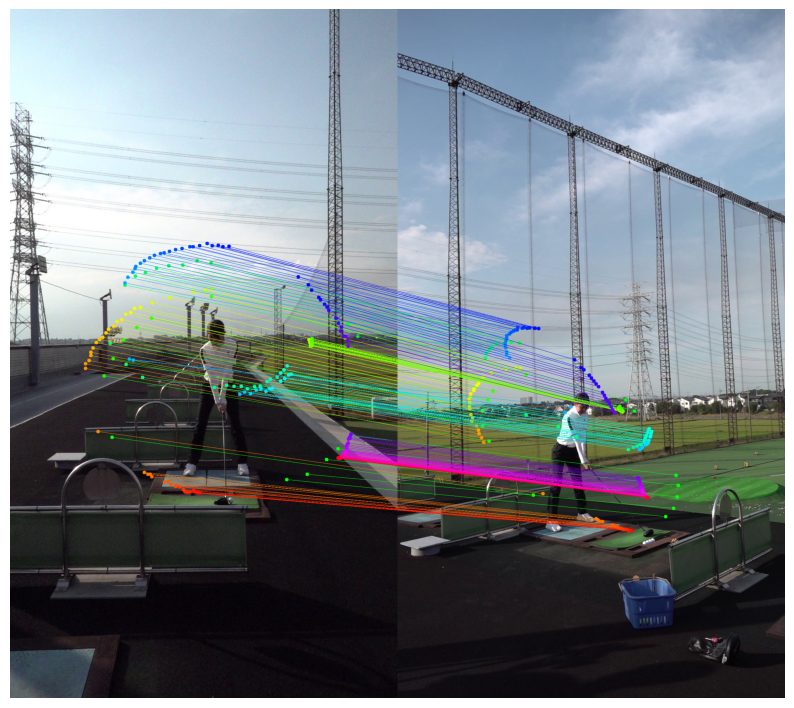

In [22]:
img_num = 50

img1 = cv2.imread(f'../data/img/red_0712_0016/red_0712_0016_{img_num}.jpg')
img2 = cv2.imread(f'../data/img/white_0712_0016/white_0712_0016_{img_num - delay_frame}.jpg')

draw_feature_matches(img1, img2, pts1, pts2)

In [23]:
reconstructed_3d = reconstruct_3D(pts1, pts2, K, R, T)
visualize_3d_points(reconstructed_3d)

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', marker=dict(size=10, color='blue'), name='Camera 1'))
fig.add_trace(go.Scatter3d(x=[T[0]], y=[T[1]], z=[T[2]], mode='markers', marker=dict(size=10, color='red'), name='Camera 2'))
fig.add_trace(go.Scatter3d(x=reconstructed_3d[0, :], y=reconstructed_3d[1, :], z=reconstructed_3d[2, :], mode='markers', marker=dict(size=5, color='green', opacity=0.5), name='Observed Points (R1, t)'))
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'), title="Camera Positions in 3D")
fig.show()

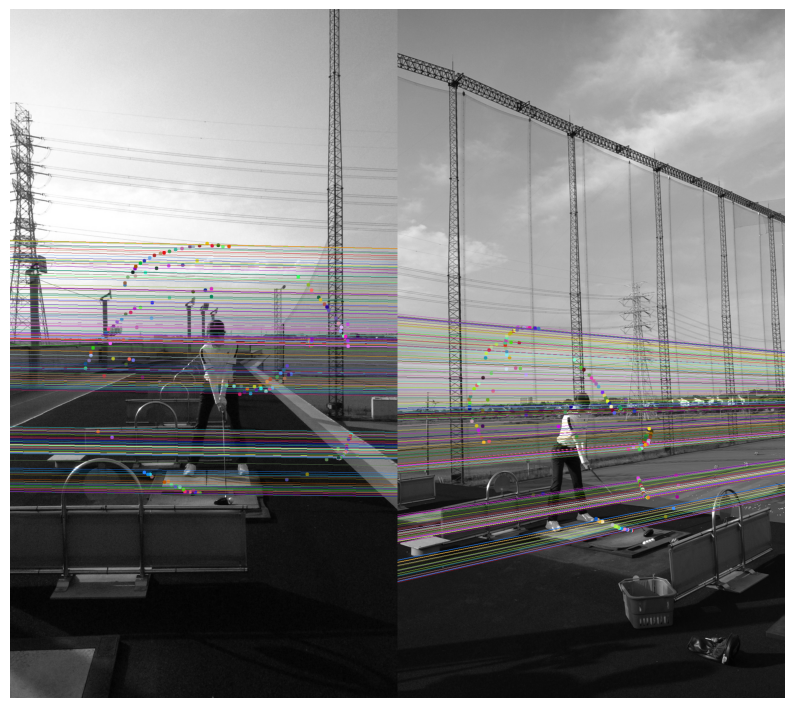

In [25]:
img_num = 50

gray_img1 = cv2.imread(f'../data/img/red_0712_0016/red_0712_0016_{img_num}.jpg', 0)
gray_img2 = cv2.imread(f'../data/img/white_0712_0016/white_0712_0016_{img_num - delay_frame}.jpg', 0)

draw_epipolar_lines(gray_img1, gray_img2, pts1, pts2, F)

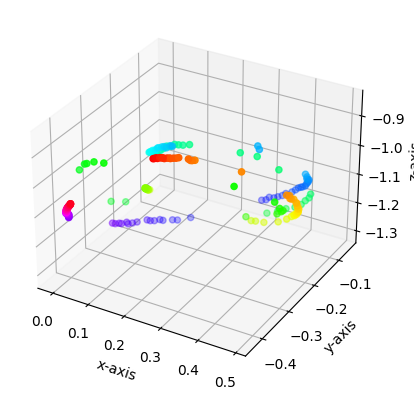

In [26]:
plot_3d_points(reconstructed_3d)

In [27]:
pose1 = pd.read_csv('../data/pose/data/red_0712_0016/position_data.csv')
pose2 = pd.read_csv('../data/pose/data/white_0712_0016/position_data.csv')

In [28]:
height, width, _ = img1.shape

for c in pose1.columns[1::2]:
    pose1[c] = pose1[c] * width
    pose2[c] = pose2[c] * width
for c in pose1.columns[2::2]:
    pose1[c] = pose1[c] * height
    pose2[c] = pose2[c] * height

In [29]:
num = 150

pts3 = np.float32(pose1.iloc[num, 1:].values)
pts4 = np.float32(pose2.iloc[num-delay_frame, 1:].values)

pts3 = pts3.reshape((-1, 2))
pts4 = pts4.reshape((-1, 2))

pts5 = np.vstack((pts1, pts3))
pts6 = np.vstack((pts2, pts4))

reconstructed_3d = reconstruct_3D(pts5, pts6, K, R, T)
visualize_3d_points(reconstructed_3d)

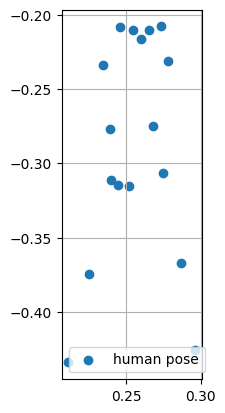

In [30]:
reconstructed_3d = reconstruct_3D(pts3, pts4, K, R, T)
fig, ax = plt.subplots()
ax.scatter(reconstructed_3d[0], reconstructed_3d[1], label='human pose')
ax.legend()
ax.set_aspect('equal')
ax.grid()
plt.show()

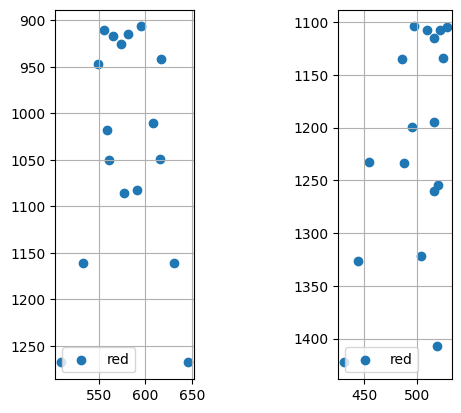

In [31]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(pose1.filter(like='_x').iloc[num].values, pose1.filter(like='_y').iloc[num].values, label='red')
ax[0].legend()
ax[0].set_aspect('equal')
ax[0].invert_yaxis()
ax[0].grid()

ax[1].scatter(pose2.filter(like='_x').iloc[num].values, pose2.filter(like='_y').iloc[num].values, label='red')
ax[1].legend()
ax[1].set_aspect('equal')
ax[1].invert_yaxis()
ax[1].grid()
plt.show()

In [32]:
from swing3dify.config import POSE_KEYPOINTS

reconstructed_3d = reconstruct_3D(pts3, pts4, K, R, T).T.flatten()
keypoint_labels = np.array([[f'{k}_x', f'{k}_y', f'{k}_z'] for k in POSE_KEYPOINTS]).flatten()
df = pd.DataFrame(columns=keypoint_labels)
df.loc[num] = reconstructed_3d
df.head()

,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,LEFT_EAR_x,LEFT_EAR_y,LEFT_EAR_z,RIGHT_EAR_x,RIGHT_EAR_y,RIGHT_EAR_z,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,LEFT_ELBOW_x,LEFT_ELBOW_y,LEFT_ELBOW_z,RIGHT_ELBOW_x,RIGHT_ELBOW_y,RIGHT_ELBOW_z,LEFT_WRIST_x,LEFT_WRIST_y,LEFT_WRIST_z,RIGHT_WRIST_x,RIGHT_WRIST_y,RIGHT_WRIST_z,LEFT_HIP_x,LEFT_HIP_y,LEFT_HIP_z,RIGHT_HIP_x,RIGHT_HIP_y,RIGHT_HIP_z,LEFT_KNEE_x,LEFT_KNEE_y,LEFT_KNEE_z,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z
150,0.259645,-0.216032,-1.047759,0.254706,-0.210386,-1.04772,0.265508,-0.210386,-1.049304,0.24567,-0.207786,-1.050723,0.27355,-0.207738,-1.053315,0.234387,-0.233943,-1.066386,0.277725,-0.23124,-1.053361,0.238677,-0.276962,-1.058241,0.267774,-0.27492,-1.039764,0.244356,-0.314398,-1.030557,0.251724,-0.314853,-1.024641,0.239558,-0.310957,-1.083995,0.274969,-0.306556,-1.07435,0.22506,-0.374438,-1.062434,0.286835,-0.366996,-1.045386,0.21087,-0.434061,-1.04108,0.296336,-0.425394,-1.022771


In [33]:
from swing3dify.visualizations import show_3d_human_pose
show_3d_human_pose(df, num)

# 3次元再構成

In [34]:
club1 = pd.read_csv('../data/club/data/red_0712_0016/position_data.csv')
club2 = pd.read_csv('../data/club/data/white_0712_0016/position_data.csv')

In [35]:
club1.interpolate(method='linear', both=True, inplace=True)
club2.interpolate(method='linear', both=True, inplace=True)

In [36]:
drop_columns = ['BOX_x', 'BOX_y', 'BOX_width', 'BOX_height']
club1.drop(columns=drop_columns, inplace=True)
club2.drop(columns=drop_columns, inplace=True)

In [37]:
pose1 = pd.read_csv('../data/pose/data/red_0712_0016/position_data.csv')
pose2 = pd.read_csv('../data/pose/data/white_0712_0016/position_data.csv')

In [38]:
pose1.interpolate(method='linear', both=True, inplace=True)
pose2.interpolate(method='linear', both=True, inplace=True)

In [39]:
delay_frame = ta.calculate_delay_frame(club1, club2, 'HOSEL')
print(f'delay_frame: {delay_frame}')

delay_frame: -32


In [40]:
club1_min = club1.index.min()
club1_max = club1.index.max()
club2_min = club2.index.min() + delay_frame
club2_max = club2.index.max() + delay_frame

min_index = max(club1_min, club2_min)
max_index = min(club1_max, club2_max)
print(f'min_index: {min_index}, max_index: {max_index}')

min_index: 0, max_index: 630


In [41]:
df1 = pose1.merge(club1, on='frame')
df2 = pose2.merge(club2, on='frame')

In [42]:
df1 = df1.iloc[min_index:max_index].copy()
df2 = df2.iloc[min_index-delay_frame:max_index-delay_frame].copy()

df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

In [43]:
height, width = 1920, 1080

for c in df1.columns[1::2]:
    df1[c] = df1[c] * width
    df2[c] = df2[c] * width
for c in df1.columns[2::2]:
    df1[c] = df1[c] * height
    df2[c] = df2[c] * height

In [44]:
from swing3dify.config import ALL_KEYPOINTS

keypoint_labels = np.array([[f'{k}_x', f'{k}_y', f'{k}_z'] for k in ALL_KEYPOINTS]).flatten()
df = pd.DataFrame(columns=keypoint_labels)

In [45]:
for frame in df1.index:
    pts1 = np.float32(df1.iloc[frame, 1:].values).reshape((-1, 2))
    pts2 = np.float32(df2.iloc[frame, 1:].values).reshape((-1, 2))

    reconstructed_3d = reconstruct_3D(pts1, pts2, K, R, T)
    df.loc[len(df)] = reconstructed_3d.T.flatten()
df.insert(0, 'frame', range(min_index, max_index))

In [46]:
from swing3dify.visualizations import show_3d_swing_pose
show_3d_swing_pose(df, 25, SAVE_PATH='../results/sample/3d_swing_pose.html')

In [47]:
df.to_csv('../data/sample/3d_position_data.csv', index=False, header=True)

# GIF

In [48]:
from matplotlib.animation import FuncAnimation

def update(num, ax):
    ax.view_init(30, 3.6*num)

In [49]:
connections = [
    ("GRIP", "HOSEL"),
    ("LEFT_EYE", "RIGHT_EYE"),
    ("LEFT_SHOULDER", "RIGHT_SHOULDER"),
    ("LEFT_SHOULDER", "LEFT_ELBOW"),
    ("RIGHT_SHOULDER", "RIGHT_ELBOW"),
    ("LEFT_ELBOW", "LEFT_WRIST"),
    ("RIGHT_ELBOW", "RIGHT_WRIST"),
    ("LEFT_HIP", "RIGHT_HIP"),
    ("LEFT_SHOULDER", "LEFT_HIP"),
    ("RIGHT_SHOULDER", "RIGHT_HIP"),
    ("LEFT_HIP", "LEFT_KNEE"),
    ("RIGHT_HIP", "RIGHT_KNEE"),
    ("LEFT_KNEE", "LEFT_ANKLE"),
    ("RIGHT_KNEE", "RIGHT_ANKLE"),
]

In [50]:
first_row = df.iloc[150]

x = first_row[1::3].values
y = first_row[2::3].values
z = first_row[3::3].values

In [51]:
tick_interval = 0.01

min_x_value = min(x)
max_x_value = max(x)
min_y_value = min(y)
max_y_value = max(y)
min_z_value = min(z)
max_z_value = max(z)

min_x_value = int(min_x_value / tick_interval) * tick_interval - tick_interval
max_x_value = int(max_x_value / tick_interval) * tick_interval
min_y_value = int(min_y_value / tick_interval) * tick_interval - tick_interval
max_y_value = int(max_y_value / tick_interval) * tick_interval
min_z_value = int(min_z_value / tick_interval) * tick_interval - tick_interval
max_z_value = int(max_z_value / tick_interval) * tick_interval

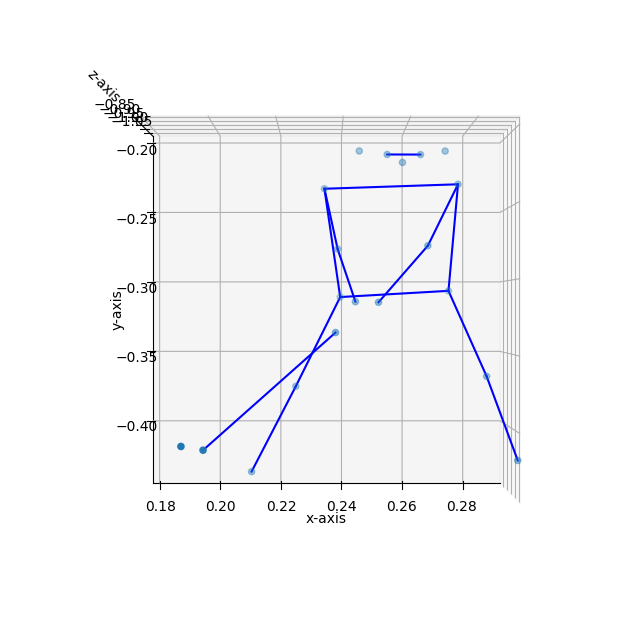

In [52]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)

for start, end in connections:
    x_values = [first_row[start + "_x"], first_row[end + "_x"]]
    y_values = [first_row[start + "_y"], first_row[end + "_y"]]
    z_values = [first_row[start + "_z"], first_row[end + "_z"]]
    ax.plot(x_values, y_values, z_values, color="blue")

ax.set_xlim(min_x_value, max_x_value)
ax.set_ylim(min_y_value, max_y_value)
ax.set_zlim(min_z_value, max_z_value)

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.view_init(azim=-90, elev=90)

ax.set_box_aspect([1, 1, 1])
plt.show()

In [53]:
ani = FuncAnimation(fig, update, frames=range(100), fargs=(ax,), blit=False)

gif_path_y_vertical = "../results/sample/3d_pose.gif"
ani.save(gif_path_y_vertical, writer='pillow', fps=10)